# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [37]:
from random import random, seed
from itertools import product, accumulate
import numpy as np
from tqdm.auto import tqdm
from icecream import ic
from matplotlib import pyplot as plt

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [38]:
UNIVERSE_SIZE = 10000
NUM_SETS = 1000
DENSITY = 0.2
MAX_STEPS = 10000

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [39]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)


## Helper Functions

In [40]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

def fitness(solution: np.ndarray) -> tuple:
    selected_sets = SETS[solution]  
    covered_items = np.sum(np.any(selected_sets, axis=0))  
    return (covered_items, -cost(solution))

## Have Fun!

In [41]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
valid(solution), cost(solution)

(np.True_, np.float64(4276551.133518897))

In [42]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
valid(solution), cost(solution)

(np.True_, np.float64(2141350.5689260596))

## Hill Climbing Single_Mutation 

 46%|████▋     | 4636/10000 [00:09<00:10, 508.75it/s] 
ic| valid(solution): np.True_
ic| fitness(solution): (np.int64(10000), np.float64(-132405.6593408419))


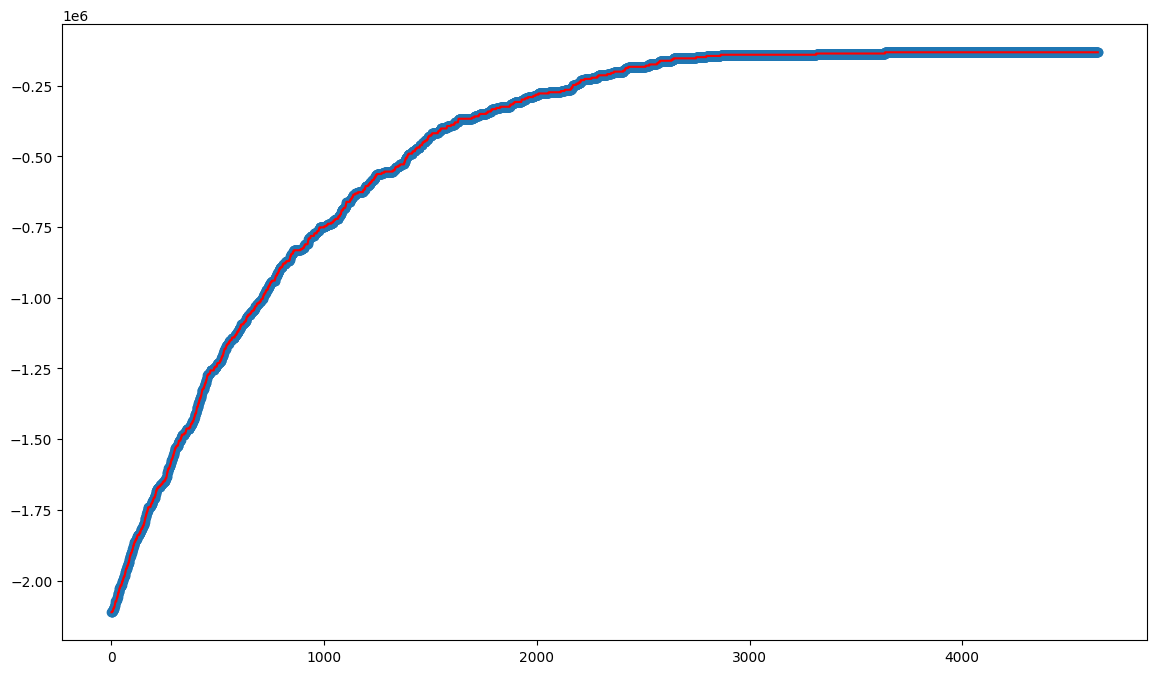

In [43]:
def single_mutation(solution: np.ndarray)-> np.ndarray:
    new_solution = solution.copy()
    i=rng.integers(0, NUM_SETS)
    new_solution[i]=not new_solution[i]
    return new_solution

solution = rng.random(NUM_SETS) < 0.5
history = [float(fitness(solution)[1])]
N = 1000
NO_Improvement_Steps = 0

for n in tqdm(range(MAX_STEPS)):
    new_solution = single_mutation(solution)
    history.append(float(fitness(solution)[1]))
    if fitness(new_solution) > fitness(solution):
        solution = new_solution  
        solution_fitness=fitness(solution)
        NO_Improvement_Steps=0
    else: 
        NO_Improvement_Steps+=1

    if NO_Improvement_Steps>N:
        break    

ic(valid(solution))
ic(fitness(solution))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history)




# Hill Climbing Multiple_Mutation

 64%|██████▎   | 6374/10000 [00:09<00:05, 682.16it/s] 
ic| valid(solution): np.True_
ic| fitness(solution): (np.int64(10000), np.float64(-122094.23460353859))


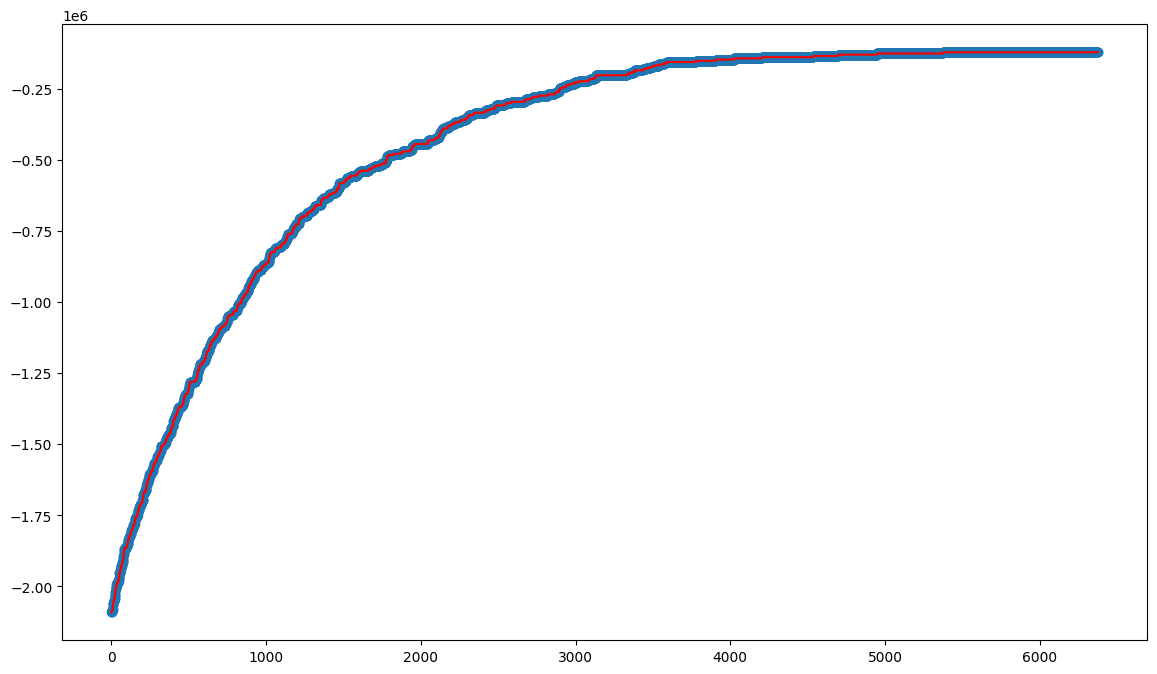

In [44]:
def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_solution = solution.copy()
    index = None 
    while index is None or np.random.random() < 0.4:
        index = rng.integers(0, NUM_SETS)
        new_solution[index] = not new_solution[index]
    return new_solution

solution = rng.random(NUM_SETS) < 0.5
history = [float(fitness(solution)[1])]
N = 1000
NO_Improvement_Steps = 0

for n in tqdm(range(MAX_STEPS)):
    new_solution = multiple_mutation(solution)
    history.append(float(fitness(solution)[1]))
    if fitness(new_solution) > fitness(solution):
        solution = new_solution  
        solution_fitness=fitness(solution)
        NO_Improvement_Steps=0
    else: 
        NO_Improvement_Steps+=1

    if NO_Improvement_Steps>N:
        break    

ic(valid(solution))
ic(fitness(solution))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history)

ic| solution_fitness: (np.float64(50.209349615585914), np.float64(-2177200.919125145))
ic| fitness(solution): (np.float64(50.209349615585914), np.float64(-2177200.919125145))
 68%|██████▊   | 6795/10000 [00:02<00:01, 2455.43it/s]
ic| "finale": 'finale'
    solution_fitness: (np.float64(50.209349615585914), np.float64(-122061.43443888592))
ic| valid(solution): np.True_
    cost(solution): np.float64(122061.43443888592)


(np.True_, np.float64(122061.43443888592))

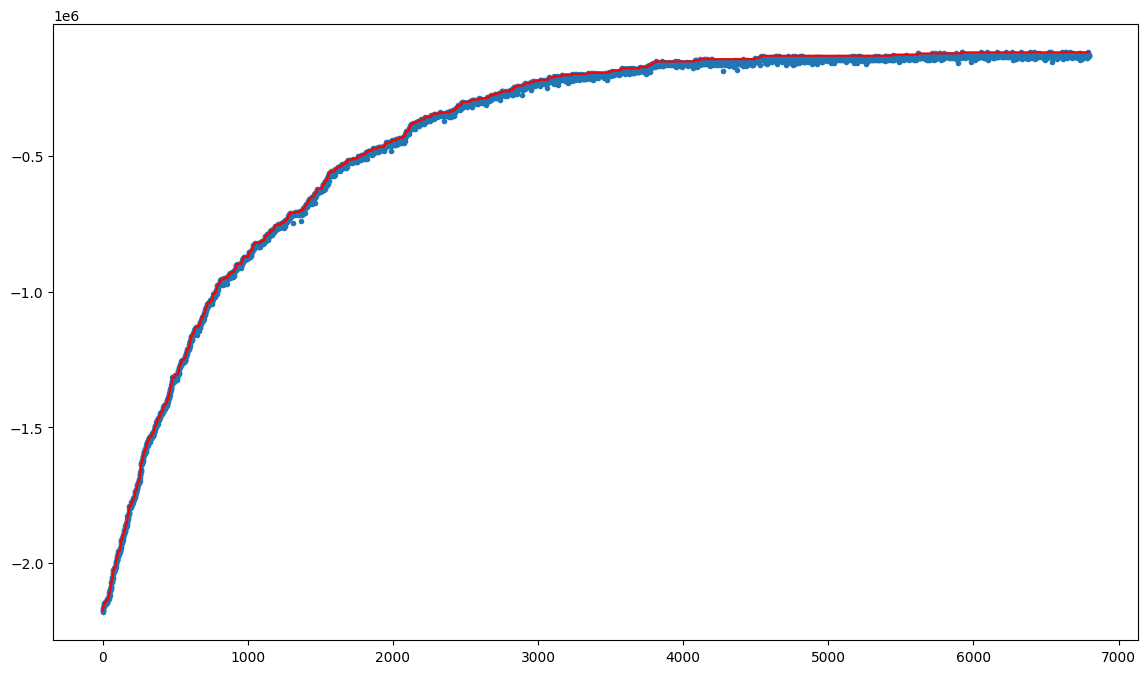

In [45]:
element_frequencies = np.sum(SETS, axis=0)  
rarity = 1 / (element_frequencies + 1e-6)  

def fitness(solution: np.ndarray) -> tuple:
    selected_sets = SETS[solution]
    covered_items = np.any(selected_sets, axis=0)  
    rarity_score = np.sum(covered_items * rarity)  
    return (rarity_score, -cost(solution))  

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_solution = solution.copy()
    index = None
    while index is None or np.random.random() < 0.4:
        index = np.random.randint(0, NUM_SETS)
        new_solution[index] = not new_solution[index]
    return new_solution

solution = rng.random(NUM_SETS) < 0.5
selected_sets = SETS[solution]
solution_fitness = fitness(solution)
ic(solution_fitness)
history = [float(solution_fitness[1])]
ic(fitness(solution))
tweak = multiple_mutation
N = 1000
NO_Improvement_Steps = 0


for n in tqdm(range(MAX_STEPS)):
    new_solution = tweak(solution)  # Genera una nuova soluzione
    f = fitness(new_solution)  # Calcola la fitness della nuova soluzione
    
    history.append(float(f[1]))  # Salva il costo corrente
    if f > solution_fitness:  # Migliora se ha un punteggio di rarità più alto o costo inferiore
        solution = new_solution
        solution_fitness = f  # Aggiorna la fitness corrente
        NO_Improvement_Steps=0
    else: 
        NO_Improvement_Steps+=1

    if NO_Improvement_Steps>N:
        break    

# Grafico della cronologia dei costi
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),  # Miglioramento cumulativo
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

# Verifica finale
ic("finale", solution_fitness)
ic(valid(solution), cost(solution))